In [1]:
!pip install --upgrade torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121


In [2]:
!pip install nibabel

In [3]:
!pip install monai

In [5]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR, UNETR
from monai.utils import set_determinism
from monai import data
from monai.data import decollate_batch
from functools import partial


import torch


print_config()

MONAI version: 1.4.0
Numpy version: 1.26.3
Pytorch version: 2.7.1+cu126
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.21.0
scipy version: 1.11.2
Pillow version: 9.5.0
Tensorboard version: 2.15.1
gdown version: 4.7.1
TorchVision version: 0.22.1+cu126
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.0
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.35.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
   

In [6]:
set_determinism(seed=0)

In [7]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = "/notebooks/elmar"
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpq1v_clxx


In [8]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)


def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val


def save_checkpoint(model, epoch, filename="model.pt", best_acc=0, dir_add=root_dir):
    state_dict = model.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
    filename = os.path.join(dir_add, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

In [9]:
from monai.transforms import (
    LoadImaged,
    Orientationd,
    Spacingd,
    ScaleIntensityRanged,
    RandSpatialCropd,
    RandFlipd,
    RandRotate90d,
    ToTensord,
    LambdaD,
)

train_transform = transforms.Compose([
    LoadImaged(keys=["image", "label"]),
    LambdaD(keys=["image", "label"], func=lambda x: x[None] if x.ndim == 3 else x),  # Add channel dim if missing
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=500, b_min=0.0, b_max=1.0, clip=True),
    RandSpatialCropd(keys=["image", "label"], roi_size=(96, 96, 96), random_size=False),
    RandFlipd(keys=["image", "label"], spatial_axis=[0], prob=0.5),
    RandFlipd(keys=["image", "label"], spatial_axis=[1], prob=0.5),
    RandFlipd(keys=["image", "label"], spatial_axis=[2], prob=0.5),
    RandRotate90d(keys=["image", "label"], prob=0.5, max_k=3),
    ToTensord(keys=["image", "label"]),
])

val_transform = transforms.Compose([
    LoadImaged(keys=["image", "label"]),
    LambdaD(keys=["image", "label"], func=lambda x: x[None] if x.ndim == 3 else x),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=500, b_min=0.0, b_max=1.0, clip=True),
    ToTensord(keys=["image", "label"]),
])


In [11]:
def get_loader(batch_size, data_dir, json_list, fold, roi):
    # Read train and validation file paths
    train_files, validation_files = datafold_read(
        datalist=json_list,
        basedir=data_dir,
        fold=fold
    )

    # Compose training data transforms
    train_transform = transforms.Compose([
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.LambdaD(keys=["image", "label"], func=lambda x: x[None]),  # Add channel dimension
        transforms.CropForegroundd(
            keys=["image", "label"],
            source_key="image",
            allow_smaller=True
        ),
        transforms.Resized(  # <- correct name for dict-based Resize
            keys=["image", "label"],
            spatial_size=roi,
            mode="nearest"
        ),
        transforms.RandSpatialCropd(
            keys=["image", "label"],
            roi_size=roi,
            random_size=False
        ),
        transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        #transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        #transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        #transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        transforms.EnsureTyped(keys=["image", "label"]),
    ])

    # Compose validation data transforms
    val_transform = transforms.Compose([
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.LambdaD(keys=["image", "label"], func=lambda x: x[None]),
        transforms.Resized(
            keys=["image", "label"],
            spatial_size=roi,
            mode="nearest"
        ),
        #transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        transforms.EnsureTyped(keys=["image", "label"]),
    ])

    # Create datasets
    train_ds = data.Dataset(data=train_files, transform=train_transform)
    val_ds = data.Dataset(data=validation_files, transform=val_transform)

    # Create data loaders
    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )

    val_loader = data.DataLoader(
        val_ds,
        batch_size=2,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    return train_loader, val_loader

print("get_loader: using Resized (dictionary transform), fully 3D-ready!")


get_loader: using Resized (dictionary transform), fully 3D-ready!


# Create DynUNet model

In [12]:
data_dir = "/notebooks/elmar/uterUS_preprocesed_Hybrid"
json_list = "uterUS_folds.json"
roi = (128, 128, 128)
batch_size = 1
sw_batch_size = 2
fold = 1
infer_overlap = 0.5
train_loader, val_loader = get_loader(batch_size, data_dir, json_list, fold, roi)

image shape: (250, 199, 125), label shape: (250, 199, 125)


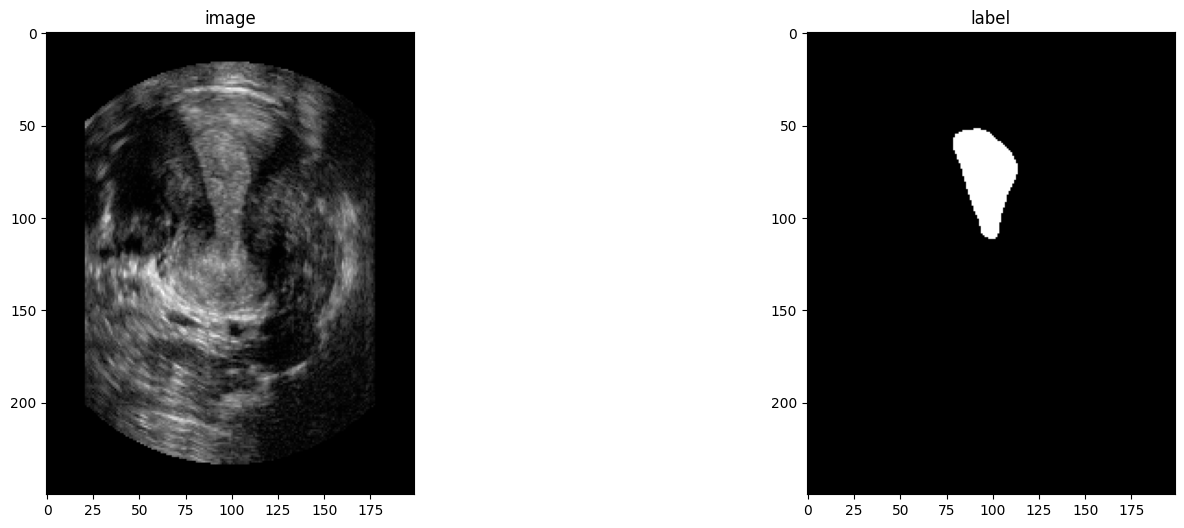

In [13]:
img_add = os.path.join(data_dir, "/notebooks/elmar/uterUS_preprocesed_Hybrid/uterUS_04_30/04_30_image.nii.gz")
label_add = os.path.join(data_dir, "/notebooks/elmar/uterUS_preprocesed_Hybrid/uterUS_04_30/04_30_seg.nii.gz")
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
print(f"image shape: {img.shape}, label shape: {label.shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[:, :, 60], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 60], cmap="gray", vmin = 0, vmax = 1)
plt.show()

In [14]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from monai.networks.nets import DynUNet

model = DynUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    kernel_size=[3, 5, 5, 3],
    strides=[1, 2, 2, 2],
    upsample_kernel_size=[2, 2, 2],
    filters=[16, 32, 64, 128, 256],  # <== Explicit channels
    res_block=True,
).to(device)

In [15]:
torch.backends.cudnn.benchmark = True
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True)
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)
dice_acc = DiceMetric(include_background=True, reduction=MetricReduction.MEAN_BATCH, get_not_nans=True)
max_epochs = 100
model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

In [16]:
def train_epoch(model, loader, optimizer, epoch, loss_func):
    model.train()
    start_time = time.time()
    run_loss = AverageMeter()

    for idx, batch_data in enumerate(loader):
        data, target = batch_data["image"].to(device), batch_data["label"].to(device)

        # Forward and backward
        logits = model(data)
        loss = loss_func(logits, target)
        optimizer.zero_grad()  # Reset gradients
        loss.backward()
        optimizer.step()

        # Update average loss
        run_loss.update(loss.item(), n=batch_size)

        print(
            f"Epoch {epoch}/{max_epochs - 1} {idx}/{len(loader)} "
            f"loss: {run_loss.avg:.4f}, time {time.time() - start_time:.2f}s"
        )
        start_time = time.time()

    return run_loss.avg


def val_epoch(model, loader, epoch, acc_func, model_inferer, post_sigmoid, post_pred):
    model.eval()
    start_time = time.time()
    run_acc = AverageMeter()

    with torch.no_grad():
        for idx, batch_data in enumerate(loader):
            data, target = batch_data["image"].to(device), batch_data["label"].to(device)
            logits = model_inferer(data)

            if post_sigmoid is not None:
                logits = post_sigmoid(logits)
            if post_pred is not None:
                logits = post_pred(logits)

            # Single foreground class, so acc is a single number
            acc, not_nans = acc_func(logits, target)
            run_acc.update(acc.cpu().numpy(), n=not_nans.cpu().numpy())

            if idx % 10 == 0:
                print(
                    f"Val {epoch}/{max_epochs - 1} {idx}/{len(loader)} "
                    "Dice: {run_acc.avg[0]:.4f}, time {time.time() - start_time:.2f}s"
                )
                start_time = time.time()

    # Only one Dice score for binary segmentation
    dice_score = run_acc.avg.item() if hasattr(run_acc.avg, 'item') else run_acc.avg[0]
    return [dice_score]


In [17]:
def trainer(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_func,
    acc_func,
    scheduler,
    model_inferer=None,
    start_epoch=0,
    post_sigmoid=None,
    post_pred=None,
):
    val_acc_max = 0.0
    dices_avg = []
    loss_epochs = []
    trains_epoch = []

    for epoch in range(start_epoch, max_epochs):
        print(time.ctime(), "Epoch:", epoch)
        epoch_time = time.time()

        # ---- Training ----
        train_loss = train_epoch(
            model,
            train_loader,
            optimizer,
            epoch=epoch,
            loss_func=loss_func,
        )

        print(
            f"Final training {epoch}/{max_epochs - 1}, "
            f"loss: {train_loss:.4f}, time: {time.time() - epoch_time:.2f}s"
        )

        # ---- Validation ----
        if (epoch + 1) % val_every == 0 or epoch == 0:
            loss_epochs.append(train_loss)
            trains_epoch.append(int(epoch))
            epoch_time = time.time()

            dice_score = val_epoch(
                model,
                val_loader,
                epoch=epoch,
                acc_func=acc_func,
                model_inferer=model_inferer,
                post_sigmoid=post_sigmoid,
                post_pred=post_pred,
            )
            dice_score = dice_score[0]  # Extract the actual Dice number

            print(
                f"Final validation stats {epoch}/{max_epochs - 1}, "
                f"dice: {dice_score:.4f}, "
                f"time: {time.time() - epoch_time:.2f}s"
            )

            dices_avg.append(dice_score)

            # Save best model to /notebooks/elmar
            if dice_score > val_acc_max:
                print(f"New best ({val_acc_max:.6f} --> {dice_score:.6f})")
                val_acc_max = dice_score
                save_path = "/notebooks/elmar/best_model_Hybrid.pth"
                torch.save(model.state_dict(), save_path)
                print(f"Saved best model to {save_path}")

            scheduler.step()

    print("Training Finished! Best Accuracy:", val_acc_max)

    return (
        val_acc_max,
        dices_avg,
        loss_epochs,
        trains_epoch,
    )



In [19]:
# Set parameters
max_epochs = 100
start_epoch = 0
val_every = 1

# Call the trainer
(
    val_acc_max,
    dices_avg,
    loss_epochs,
    trains_epoch,
) = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=dice_loss,
    acc_func=dice_acc,
    scheduler=scheduler,
    model_inferer=model_inferer,
    start_epoch=start_epoch,
    post_sigmoid=post_sigmoid,
    post_pred=post_pred,
)

Thu Jun 12 07:07:16 2025 Epoch: 0
Epoch 0/99 0/91 loss: 0.9803, time 0.30s
Epoch 0/99 1/91 loss: 0.9760, time 0.27s
Epoch 0/99 2/91 loss: 0.9754, time 0.35s
Epoch 0/99 3/91 loss: 0.9634, time 0.26s
Epoch 0/99 4/91 loss: 0.9659, time 0.29s
Epoch 0/99 5/91 loss: 0.9553, time 0.28s
Epoch 0/99 6/91 loss: 0.9594, time 0.34s
Epoch 0/99 7/91 loss: 0.9594, time 0.28s
Epoch 0/99 8/91 loss: 0.9607, time 0.27s
Epoch 0/99 9/91 loss: 0.9603, time 0.35s
Epoch 0/99 10/91 loss: 0.9596, time 0.37s
Epoch 0/99 11/91 loss: 0.9578, time 0.28s
Epoch 0/99 12/91 loss: 0.9579, time 0.41s
Epoch 0/99 13/91 loss: 0.9600, time 0.48s
Epoch 0/99 14/91 loss: 0.9602, time 0.30s
Epoch 0/99 15/91 loss: 0.9618, time 0.48s
Epoch 0/99 16/91 loss: 0.9617, time 0.29s
Epoch 0/99 17/91 loss: 0.9604, time 0.24s
Epoch 0/99 18/91 loss: 0.9611, time 0.25s
Epoch 0/99 19/91 loss: 0.9578, time 0.26s
Epoch 0/99 20/91 loss: 0.9575, time 0.28s
Epoch 0/99 21/91 loss: 0.9580, time 0.26s
Epoch 0/99 22/91 loss: 0.9588, time 0.27s
Epoch 0/99

In [21]:
print(f"train completed, best average dice: {val_acc_max:.4f} ")

train completed, best average dice: 0.8643 


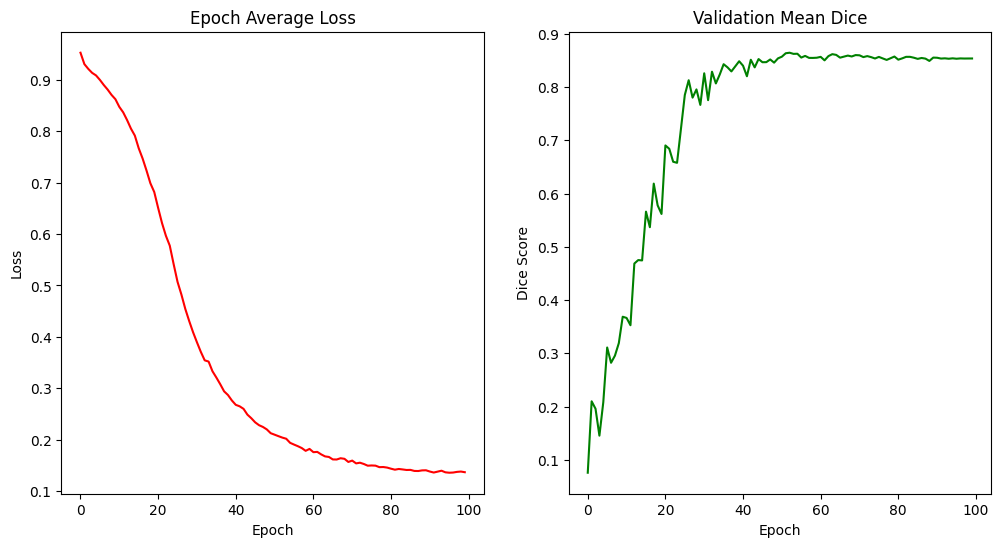

In [22]:
import matplotlib.pyplot as plt

# Plot 1: Epoch Average Loss and Validation Mean Dice
plt.figure("train", (12, 6))

plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(trains_epoch, loss_epochs, color="red")

plt.subplot(1, 2, 2)
plt.title("Validation Mean Dice")
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.plot(trains_epoch, dices_avg, color="green")

plt.show()




In [24]:
import os
from monai.data import Dataset, DataLoader
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    ScaleIntensityd,
    EnsureTyped,
)

# Example for one test case
case_num = "04_02"

# Define the data directory
data_dir = "/notebooks/elmar/uterUS_testing"

# Construct the test_files dictionary
test_files = [
    {
        "image": os.path.join(data_dir, f"uterUS_{case_num}/{case_num}_image.nii.gz"),
        "label": os.path.join(data_dir, f"uterUS_{case_num}/{case_num}_seg.nii.gz"),
    }
]

# Define the test transforms pipeline
test_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),  # 1-channel 3D data
        ScaleIntensityd(keys=["image"]),               # intensity normalization
        EnsureTyped(keys=["image", "label"]),          # ensure correct data type
    ]
)

# Create the dataset and dataloader
test_ds = Dataset(data=test_files, transform=test_transform)

test_loader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

print("Test loader created successfully!")


Test loader created successfully!


In [25]:
from monai.inferers import sliding_window_inference
from functools import partial

model_inferer_test = partial(
    sliding_window_inference,
    roi_size=[128, 128, 128],  # adjust to your actual ROI
    sw_batch_size=2,
    predictor=model,
    overlap=0.6,
)

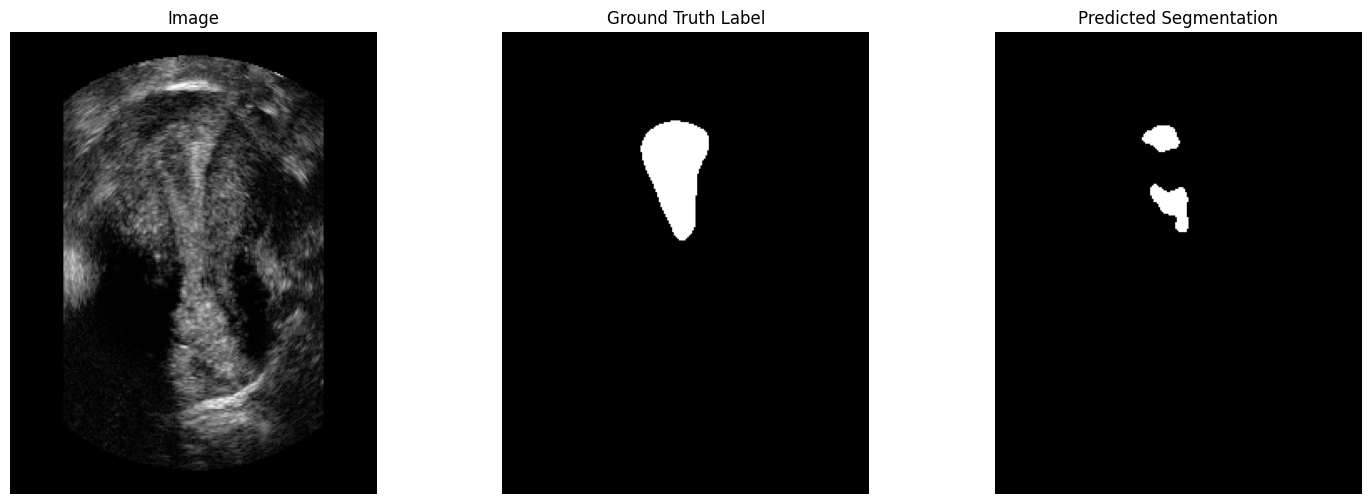

In [26]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os

# Inference on test data
with torch.no_grad():
    for batch_data in test_loader:
        image = batch_data["image"].to(device)
        prob = torch.sigmoid(model_inferer_test(image))
        prob = prob[0].detach().cpu().numpy()
        seg = (prob > 0.5).astype(np.uint8)
        seg_out = seg.squeeze()  # shape (H, W, D)

# Choose a slice to visualize
slice_num = 60

# Paths for image and label
img_path = os.path.join(data_dir, f"uterUS_{case_num}/{case_num}_image.nii.gz")
label_path = os.path.join(data_dir, f"uterUS_{case_num}/{case_num}_seg.nii.gz")

# Load image and label
img = nib.load(img_path).get_fdata()
label = nib.load(label_path).get_fdata()

# Plot
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img[:, :, slice_num], cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Ground Truth Label")
plt.imshow(label[:, :, slice_num], cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Predicted Segmentation")
plt.imshow(seg_out[:, :, slice_num], cmap="gray")
plt.axis("off")

plt.show()


Dice score for this case: 0.5043


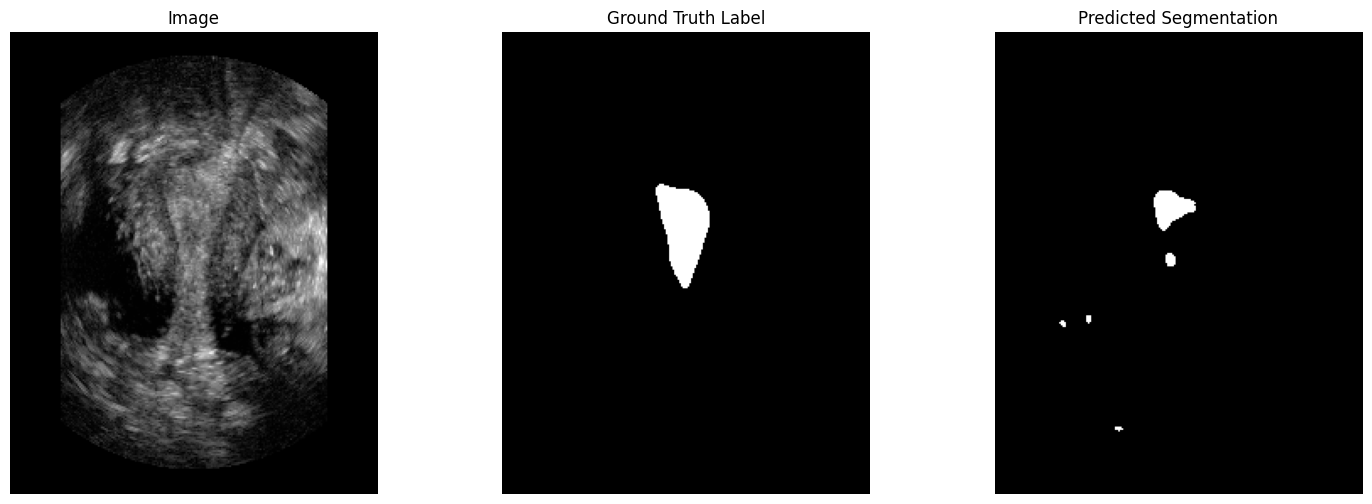

Testing finished!
Mean Dice score: 0.5043


In [27]:
import os
import torch
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
from monai.data import Dataset, DataLoader
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd, EnsureTyped
)
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import DynUNet

# --------------- SETUP ---------------
case_num = "04_03"
data_dir = "/notebooks/elmar/uterUS_testing"
root_dir = "/notebooks/elmar"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
roi = [128, 128, 128]

# --------------- Model ---------------
model = DynUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    kernel_size=[3, 5, 5, 3],
    strides=[1, 2, 2, 2],
    upsample_kernel_size=[2, 2, 2],
    filters=[16, 32, 64, 128, 256],
    res_block=True,
).to(device)

checkpoint = torch.load(os.path.join(root_dir, "best_model_Hybrid.pth"), map_location=device)
model.load_state_dict(checkpoint)
model.eval()

# --------------- Dataset & Loader ---------------
test_files = [{
    "image": os.path.join(data_dir, f"uterUS_{case_num}/{case_num}_image.nii.gz"),
    "label": os.path.join(data_dir, f"uterUS_{case_num}/{case_num}_seg.nii.gz"),
}]
test_transform = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys=["image"]),
    EnsureTyped(keys=["image", "label"]),
])
test_ds = Dataset(data=test_files, transform=test_transform)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

# --------------- Sliding Window Inference ---------------
model_inferer_test = partial(
    sliding_window_inference,
    roi_size=roi,
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
)

# --------------- Inference & Metrics ---------------
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
dice_scores = []

with torch.no_grad():
    for batch_data in test_loader:
        image = batch_data["image"].to(device)
        label = batch_data["label"].to(device)

        # Inference
        prob = torch.sigmoid(model_inferer_test(image))
        pred = (prob > 0.5).float()

        # Compute Dice
        dice_score = dice_metric(y_pred=pred, y=label).item()
        dice_scores.append(dice_score)
        print(f"Dice score for this case: {dice_score:.4f}")

        # Visualize one slice
        prob_np = prob[0].cpu().numpy().squeeze()
        seg_out = (prob_np > 0.5).astype(np.uint8)

        img_path = os.path.join(data_dir, f"uterUS_{case_num}/{case_num}_image.nii.gz")
        label_path = os.path.join(data_dir, f"uterUS_{case_num}/{case_num}_seg.nii.gz")
        img = nib.load(img_path).get_fdata()
        lbl = nib.load(label_path).get_fdata()

        slice_num = 60
        plt.figure(figsize=(18, 6))
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(img[:, :, slice_num], cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Label")
        plt.imshow(lbl[:, :, slice_num], cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("Predicted Segmentation")
        plt.imshow(seg_out[:, :, slice_num], cmap="gray")
        plt.axis("off")
        plt.show()

print("Testing finished!")
print(f"Mean Dice score: {np.mean(dice_scores):.4f}")


# Inference on Whole Test Dataset

In [30]:
import os
import numpy as np
import torch
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd, EnsureTyped
from monai.data import Dataset, DataLoader, pad_list_data_collate
from monai.networks.nets import DynUNet

# ------------- CONFIGURATION -------------
root_dir = "/notebooks/elmar"
data_dir = os.path.join(root_dir, "uterUS_testing")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
roi = [128, 128, 128]  # Adjust ROI size if needed
sw_batch_size = 1
overlap = 0.6
slice_num = 60  # Slice to visualize

# ------------- MODEL -------------
model = DynUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    kernel_size=[3, 5, 5, 3],
    strides=[1, 2, 2, 2],
    upsample_kernel_size=[2, 2, 2],
    filters=[16, 32, 64, 128, 256],
    res_block=True,
).to(device)

# Load trained weights
checkpoint = torch.load(os.path.join(root_dir, "best_model_Hybrid.pth"), map_location=device)
model.load_state_dict(checkpoint)
model.eval()

# Create sliding window inferer
model_inferer = partial(
    sliding_window_inference,
    roi_size=roi,
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=overlap,
)

# ------------- TRANSFORMS -------------
test_transform = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys=["image"]),
    EnsureTyped(keys=["image", "label"]),
])

# ------------- DATA PREPARATION -------------
test_cases = sorted([d for d in os.listdir(data_dir) if not d.startswith('.') and os.path.isdir(os.path.join(data_dir, d))])

test_files = []
for case in test_cases:
    img = os.path.join(data_dir, case, f"{case[-5:]}_image.nii.gz")
    lbl = os.path.join(data_dir, case, f"{case[-5:]}_seg.nii.gz")
    if os.path.exists(img) and os.path.exists(lbl):
        test_files.append({"image": img, "label": lbl})
    else:
        print(f"Missing data for {case}, skipping.")

print(f"Found {len(test_files)} test cases to process.")

test_ds = Dataset(data=test_files, transform=test_transform)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=pad_list_data_collate)

# ------------- METRICS & OUTPUT -------------
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
dice_scores = []

# ------------- INFERENCE & VISUALIZATION -------------
with torch.no_grad():
    for idx, batch_data in enumerate(tqdm(test_loader, desc="Inference")):
        image = batch_data["image"].to(device)
        label = batch_data["label"].to(device)

        # Inference
        prob = torch.sigmoid(model_inferer(image))
        pred = (prob > 0.5).float()

        # Compute Dice
        dice_score = dice_metric(y_pred=pred, y=label).item()
        dice_scores.append(dice_score)
        print(f"[{idx+1}/{len(test_loader)}] Dice score: {dice_score:.4f}")

        # Save prediction
        case_name = os.path.basename(os.path.dirname(test_files[idx]["image"]))
        pred_np = pred.cpu().numpy().squeeze()
        nib.save(nib.Nifti1Image(pred_np, affine=np.eye(4)),
                  os.path.join(root_dir, "predictions", f"{case_name}_prediction.nii.gz"))

        # Visualization for this case
        img_path = test_files[idx]["image"]
        label_path = test_files[idx]["label"]
        img_data = nib.load(img_path).get_fdata()
        label_data = nib.load(label_path).get_fdata()

        plt.figure(figsize=(18, 6))
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(img_data[:, :, slice_num], cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Label")
        plt.imshow(label_data[:, :, slice_num], cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("Predicted Segmentation")
        plt.imshow(pred_np[:, :, slice_num], cmap="gray")
        plt.axis("off")
        plt.show()

# ------------- FINAL RESULTS -------------
print("\nAll predictions saved.")
print(f"Mean Dice across test set: {np.mean(dice_scores):.4f}")

Found 20 test cases to process.


Inference:   0%|          | 0/20 [00:00<?, ?it/s]

[1/20] Dice score: 0.8523


NotADirectoryError: [Errno 20] Not a directory: '/notebooks/elmar/predictions/uterUS_04_01_prediction.nii.gz'